In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
np.set_printoptions(precision=3, suppress=True)

In [2]:
data_root = '../data/lightwheelocc/'

with open(data_root + 'lightwheel_occ_infos_val.pkl', 'rb') as f:
    data_infos = pickle.load(f)

print(data_infos['metadata'])

{'version': 'LightwheelOcc-v1.0', 'split': 'val'}


In [3]:
sample_data = data_infos['infos'][0]

print(sample_data.keys())

dict_keys(['token', 'prev', 'next', 'frame_idx', 'scene_token', 'timestamp', 'ego2global_rotation', 'ego2global_translation', 'lidar2ego_translation', 'lidar2ego_rotation', 'cams', 'occ_path'])


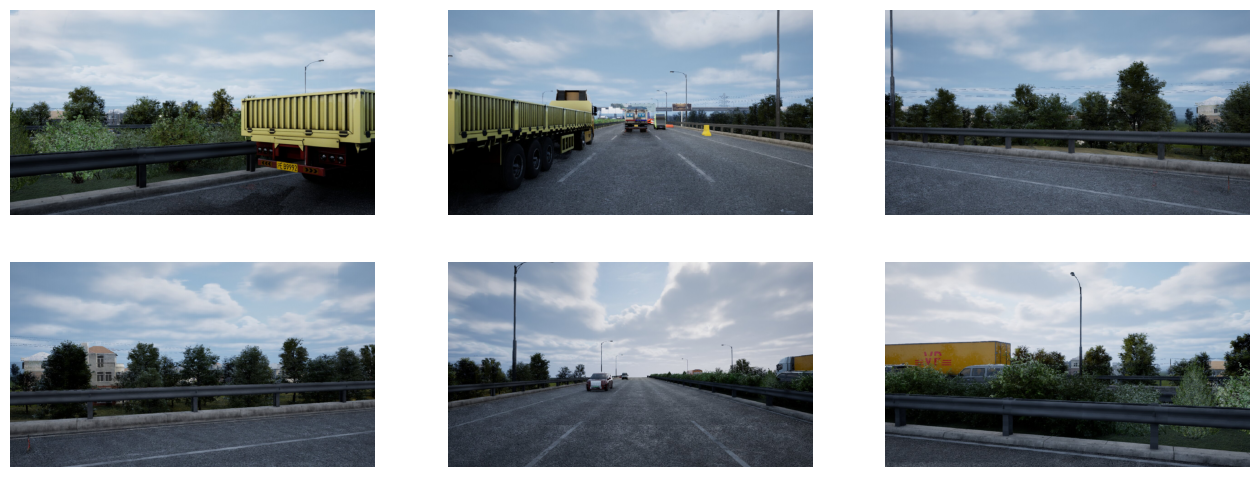

In [4]:
# read images and show
CAMS = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 'CAM_BACK', 'CAM_BACK_LEFT']
images = []
depths = []
for cam_name in CAMS:
    cam = sample_data['cams'][cam_name]
    data_path = os.path.join(data_root, cam['cam_path'])
    img = cv2.imread(data_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

    depth_path = os.path.join(data_root, cam['depth_path'])
    depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
    depth = depth_img[:,:,0] + (depth_img[:,:,1] * 256)
    depth = depth * 0.01
    depths.append(depth)

# Plot images with 3 * 2 grid
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for i, img in enumerate(images):
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')


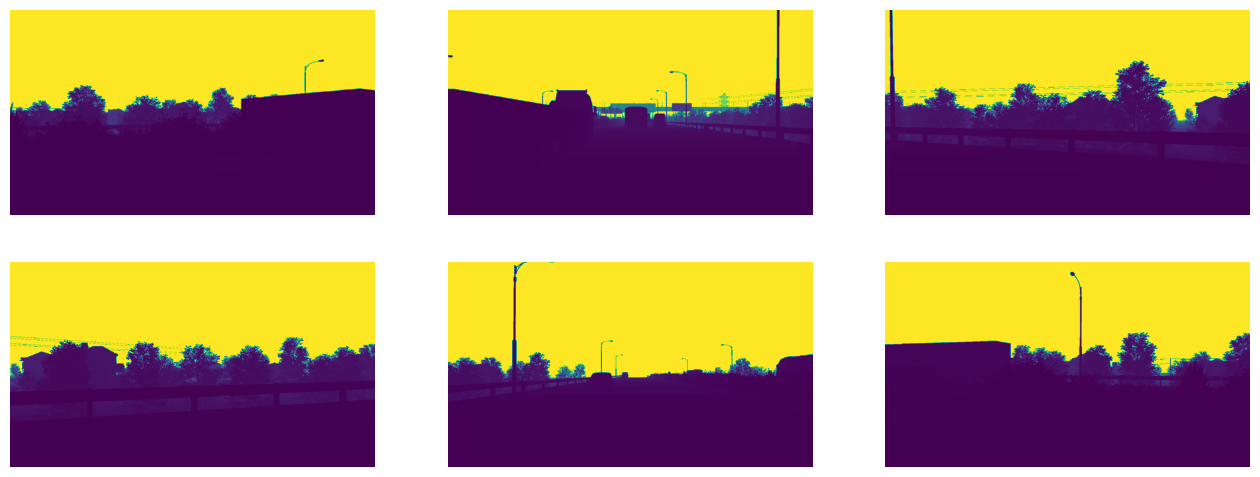

In [5]:
# read depth
depths = []
for cam_name in CAMS:
    cam = sample_data['cams'][cam_name]
    depth_path = os.path.join(data_root, cam['depth_path'])
    depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
    depth = depth_img[:,:,0] + (depth_img[:,:,1] * 256)
    depth = depth * 0.01
    # set invalid depth to 1000
    depth[depth==0] = 1000
    depths.append(depth)

fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for i, img in enumerate(depths):
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

In [6]:
# vis occupancy
occ_path = os.path.join(data_root, sample_data['occ_path'])
occ = np.load(occ_path)
print(list(occ.keys()))

['semantics', 'instances', 'flow']


In [7]:
occ_class_names = [
    'car', 'truck', 'trailer', 'bus', 'construction_vehicle',
    'bicycle', 'motorcycle', 'pedestrian', 'traffic_cone', 'barrier',
    'driveable_surface', 'other_flat', 'sidewalk',
    'terrain', 'manmade', 'vegetation', 'free'
]

color_map = np.array([
    [0, 150, 245, 255],    # car                  blue
    [160, 32, 240, 255],   # truck                purple
    [135, 60, 0, 255],     # trailer              brown
    [255, 255, 0, 255],    # bus                  yellow
    [0, 255, 255, 255],    # construction_vehicle cyan
    [255, 192, 203, 255],  # bicycle              pink
    [200, 180, 0, 255],    # motorcycle           dark orange
    [255, 0, 0, 255],      # pedestrian           red
    [255, 240, 150, 255],  # traffic_cone         light yellow
    [255, 120, 50, 255],   # barrier              orangey
    [255, 0, 255, 255],    # driveable_surface    dark pink
    [175,   0,  75, 255],  # other_flat           dark red
    [75, 0, 75, 255],      # sidewalk             dard purple
    [150, 240, 80, 255],   # terrain              light green
    [230, 230, 250, 255],  # manmade              white
    [0, 175, 0, 255],      # vegetation           green
    [255, 255, 255, 255],  # free                 white
], dtype=np.uint8)

def occ2img(semantics):
    H, W, D = semantics.shape

    free_id = len(occ_class_names) - 1
    semantics_2d = np.ones([H, W], dtype=np.int32) * free_id

    for i in range(D):
        semantics_i = semantics[..., i]
        non_free_mask = (semantics_i != free_id)
        semantics_2d[non_free_mask] = semantics_i[non_free_mask]

    viz = color_map[semantics_2d]
    viz = viz[..., :3]
    viz = cv2.resize(viz, dsize=(800, 800))

    return viz

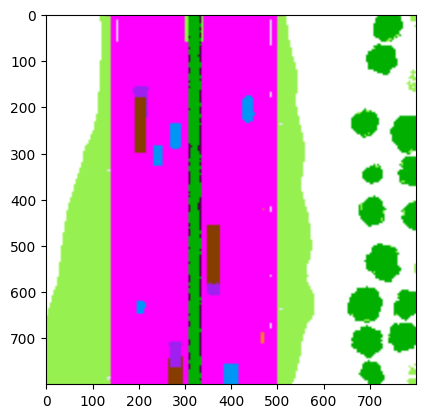

In [8]:
bev_image = occ2img(occ['semantics'])
plt.imshow(bev_image)
plt.show()